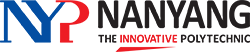

# IT2311 Assignment - Task 2: Sentiment Classification

You are required to build a sentiment classification model predict the sentiment of the review text. Businesses will be able to use this model to predict the sentiment of a new review.

Complete the following sub-tasks:
1. **Load Data**: Load the clean dataset
2. **Data Preparation**: Prepares the text representation for this task
3. **Modelling**: Perform sentiment classification using different text representation and modelling techniques
4. **Evaluation**: Evaluates results from the algorithms and select the best model

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in this Jupyter notebook**. 

**Done by: \<Clifton Chen Yi, 231220B\>**

## Import libraries and download the packages

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')

print('All libraries imported successfully.')

## Load Data

In [2]:
import pandas as pd

# Loading the dataset from JSON Lines format
task2_df_vid_game = pd.read_json('Task_2_SA_video_game_reviews.json', orient='records', lines=True)
print(f'Dataset loaded successfully with {task2_df_vid_game.shape[0]} rows and {task2_df_vid_game.shape[1]} columns.')

Dataset loaded successfully with 50000 rows and 10 columns.


In [5]:
# Displaying the first few rows of the video game reviews dataframe
task2_df_vid_game.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4,"Really Solid Controller, No extra bells and wh...",I got this controller to play smash and this i...,[],B09QJN8ZD9,B0B97J6RP5,AFI6XUILYCSXNUZM65OYWPV4REVA,2022-09-21 14:24:29.933,2,True
1,5,Daughter loves this game,My daughter has been Wanting this game forever...,[],B07SL6ZXBL,B087NNZZM8,AF2HIO5O3OJNHQ5J6BCNCDWE6MLA,2020-12-26 16:03:12.342,0,True
2,5,Great Headphones!,As I write this review I am wearing this aweso...,[],B00DU2CHE2,B00DU2CHE2,AFNFOOZZSQLBHUZVLO5Z7JELFWJA,2014-11-23 18:37:53.000,1,True
3,4,Works great so far,It came in great shape and works well.,[],B07Z8F1792,B07Z8F1792,AGEBR7OMWGHRRQLWQ4LERN75KAPQ,2019-12-28 19:18:35.767,0,True
4,5,Five Stars,A lot to do and a lot of fun doing it.,[],B006ZPAYD2,B007YZCE94,AFKO3BU6ZC2QZXW4YELBVIGNUDBQ,2014-12-10 06:50:20.000,0,True


### Explore the Dataset
Before preparing the data, let us understand the distribution of ratings and the characteristics of the text data.

In [ ]:
# Check dataset info and rating distribution
print('Dataset shape:', task2_df_vid_game.shape)
print('\nColumn data types:')
print(task2_df_vid_game.dtypes)
print('\nMissing values:')
print(task2_df_vid_game.isnull().sum())
print('\nRating distribution:')
print(task2_df_vid_game['rating'].value_counts().sort_index())

In [ ]:
# Visualise rating distribution
plt.figure(figsize=(8, 4))
task2_df_vid_game['rating'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Data Preparation
Perform the necessary steps and explain the rationale taken here.



### Rationale for Data Preparation

The following data preparation steps are performed:

1. **Sentiment Labelling**: Convert the numeric `rating` column into sentiment categories. Ratings of 1–2 are mapped to **Negative**, rating 3 to **Neutral**, and ratings 4–5 to **Positive**. This creates a 3-class classification problem that reflects how customers typically express sentiment.

2. **Text Cleaning**: Review text is lowercased, stripped of special characters and extra whitespace. This standardises the input so that the models focus on meaningful words rather than noise.

3. **Handling Missing Values**: Any rows with missing review text are dropped to avoid errors during vectorisation.

4. **Train/Test Split**: The data is split 80/20 with stratification to ensure each sentiment class is proportionally represented in both sets.

5. **TF-IDF Vectorisation**: Text is converted into numerical features using Term Frequency–Inverse Document Frequency (TF-IDF). This approach weighs words by their importance across the corpus, giving less weight to common words and more to distinctive ones. We limit to 10,000 features and use unigrams and bigrams to capture some phrase-level meaning.

In [ ]:
# Step 1: Create sentiment labels from ratings
def map_sentiment(rating):
    """Map rating to sentiment category."""
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

task2_df_vid_game['sentiment'] = task2_df_vid_game['rating'].apply(map_sentiment)
print('Sentiment distribution:')
print(task2_df_vid_game['sentiment'].value_counts())

In [ ]:
# Step 2: Text cleaning
def clean_text(text):
    """Clean review text by lowercasing and removing special characters."""
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)       # keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()    # collapse multiple spaces
    return text

task2_df_vid_game['clean_text'] = task2_df_vid_game['text'].apply(clean_text)

# Step 3: Drop rows with empty text after cleaning
before = len(task2_df_vid_game)
task2_df_vid_game = task2_df_vid_game[task2_df_vid_game['clean_text'].str.len() > 0].reset_index(drop=True)
after = len(task2_df_vid_game)
print(f'Dropped {before - after} rows with empty text. Remaining rows: {after}')
print('\nSample cleaned texts:')
task2_df_vid_game[['text', 'clean_text']].head(3)

In [ ]:
# Visualise sentiment distribution after labelling
sentiment_counts = task2_df_vid_game['sentiment'].value_counts()
color_map = {'Positive': 'green', 'Neutral': 'grey', 'Negative': 'red'}
colors = [color_map[label] for label in sentiment_counts.index]

plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Step 4: Train/Test split (80/20, stratified)
X = task2_df_vid_game['clean_text']
y = task2_df_vid_game['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Training set size: {len(X_train)}')
print(f'Test set size:     {len(X_test)}')
print(f'\nTraining label distribution:')
print(y_train.value_counts())

In [ ]:
# Step 5: TF-IDF Vectorisation
tfidf = TfidfVectorizer(
    max_features=10000,   # limit vocabulary size for efficiency
    ngram_range=(1, 2),   # unigrams + bigrams to capture phrases
    min_df=2,             # ignore terms appearing in fewer than 2 documents
    max_df=0.95           # ignore terms appearing in more than 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f'TF-IDF matrix shape (train): {X_train_tfidf.shape}')
print(f'TF-IDF matrix shape (test):  {X_test_tfidf.shape}')

## Modelling
Perform the necessary steps and explain the rationale taken here.



### Choice of Models

Three models of **different algorithm families** are selected for comparison:

| # | Model | Algorithm Family | Rationale |
|---|-------|-----------------|----------|
| 1 | **Logistic Regression** | Linear / Probabilistic | A strong baseline for text classification. It is efficient, interpretable, and works well with high-dimensional sparse TF-IDF features. |
| 2 | **Multinomial Naive Bayes** | Probabilistic / Generative | Specifically designed for count/frequency data such as TF-IDF vectors. It is computationally fast and often performs surprisingly well for text tasks. |
| 3 | **Random Forest** | Ensemble / Tree-based | A non-linear model that combines many decision trees. It captures complex feature interactions that linear models may miss. |

**Why these three?**
- They represent three distinct algorithm families (linear, probabilistic, ensemble tree-based), allowing meaningful comparison.
- None are LLM/Gen AI models, keeping the solution grounded in traditional ML approaches suitable for structured evaluation.
- Each has different strengths: Logistic Regression is interpretable, Naive Bayes is fast and effective for text, and Random Forest can model non-linear relationships.

### Model 1: Logistic Regression

Logistic Regression is a linear classifier that estimates class probabilities using a logistic (sigmoid) function. For multi-class problems it uses a one-vs-rest or multinomial strategy. It handles high-dimensional TF-IDF features well and provides interpretable coefficients.

In [ ]:
# Model 1: Logistic Regression (baseline)
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', multi_class='multinomial')
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print('=== Logistic Regression — Classification Report ===')
print(classification_report(y_test, y_pred_lr))
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}')

### Model 2: Multinomial Naive Bayes

Multinomial Naive Bayes applies Bayes' theorem with the assumption that features are conditionally independent given the class. Despite this simplifying assumption, it often performs competitively on text data because word frequencies tend to be informative of sentiment.

In [ ]:
# Model 2: Multinomial Naive Bayes
nb_model = MultinomialNB(alpha=1.0)  # Laplace smoothing
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print('=== Multinomial Naive Bayes — Classification Report ===')
print(classification_report(y_test, y_pred_nb))
print(f'Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}')

### Model 3: Random Forest

Random Forest is an ensemble method that builds multiple decision trees on random subsets of data and features, then aggregates their predictions through majority voting. It can capture non-linear relationships between TF-IDF features and sentiment.

In [ ]:
# Model 3: Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

print('=== Random Forest — Classification Report ===')
print(classification_report(y_test, y_pred_rf))
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')

## Evaluation
Perform the necessary steps and explain the rationale taken here.



### Evaluation Metrics Explained

The following metrics are used to assess each model:

- **Accuracy**: Proportion of correctly classified reviews. Gives an overall sense of model performance but can be misleading if classes are imbalanced.
- **Precision**: Of all reviews predicted as a given sentiment, how many truly belong to that class. Important when false positives are costly.
- **Recall**: Of all reviews that actually belong to a class, how many were correctly identified. Important when missing a sentiment (false negatives) is costly.
- **F1-Score**: The harmonic mean of precision and recall. Provides a single balanced measure, especially useful when class sizes differ.
- **Confusion Matrix**: A visual summary showing how predictions map to actual labels, making it easy to spot where a model confuses one class for another.

In [ ]:
# Collect evaluation results for all three models
models = {
    'Logistic Regression': y_pred_lr,
    'Naive Bayes': y_pred_nb,
    'Random Forest': y_pred_rf
}

results = []
for name, y_pred in models.items():
    results.append({
        'Model': name,
        'Accuracy':  accuracy_score(y_test, y_pred),
        'Precision (macro)': precision_score(y_test, y_pred, average='macro'),
        'Recall (macro)':    recall_score(y_test, y_pred, average='macro'),
        'F1-Score (macro)':  f1_score(y_test, y_pred, average='macro')
    })

results_df = pd.DataFrame(results).set_index('Model')
print('=== Model Comparison ===')
display(results_df.style.highlight_max(axis=0, color='lightgreen'))

In [ ]:
# Plot comparison bar chart
results_df.plot(kind='bar', figsize=(10, 5), colormap='Set2')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrices for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = sorted(y_test.unique())

for ax, (name, y_pred) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(name)

plt.suptitle('Confusion Matrices', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Model Improvement Attempts

To demonstrate understanding of model tuning and iterative improvement, the following techniques are applied:

1. **Logistic Regression**: Tune the regularisation strength (`C` parameter) using GridSearchCV. Stronger regularisation can reduce overfitting on noisy text features.
2. **Naive Bayes**: Tune the smoothing parameter (`alpha`). Lower alpha values reduce the effect of Laplace smoothing and may improve precision.
3. **Random Forest**: Tune `n_estimators` and `max_depth` to balance model complexity and generalisation.

In [ ]:
# Improvement 1: Tune Logistic Regression regularisation
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', multi_class='multinomial'),
    param_grid={'C': [0.1, 1.0, 5.0, 10.0]},
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)
lr_grid.fit(X_train_tfidf, y_train)
print(f'Best C for Logistic Regression: {lr_grid.best_params_["C"]}')
print(f'Best CV F1 (macro): {lr_grid.best_score_:.4f}')

y_pred_lr_tuned = lr_grid.predict(X_test_tfidf)
print('\n=== Tuned Logistic Regression — Classification Report ===')
print(classification_report(y_test, y_pred_lr_tuned))
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr_tuned):.4f}')

In [ ]:
# Improvement 2: Tune Naive Bayes smoothing
nb_grid = GridSearchCV(
    MultinomialNB(),
    param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]},
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)
nb_grid.fit(X_train_tfidf, y_train)
print(f'Best alpha for Naive Bayes: {nb_grid.best_params_["alpha"]}')
print(f'Best CV F1 (macro): {nb_grid.best_score_:.4f}')

y_pred_nb_tuned = nb_grid.predict(X_test_tfidf)
print('\n=== Tuned Naive Bayes — Classification Report ===')
print(classification_report(y_test, y_pred_nb_tuned))
print(f'Accuracy: {accuracy_score(y_test, y_pred_nb_tuned):.4f}')

In [ ]:
# Improvement 3: Tune Random Forest
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [30, 50, None]
    },
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)
rf_grid.fit(X_train_tfidf, y_train)
print(f'Best params for Random Forest: {rf_grid.best_params_}')
print(f'Best CV F1 (macro): {rf_grid.best_score_:.4f}')

y_pred_rf_tuned = rf_grid.predict(X_test_tfidf)
print('\n=== Tuned Random Forest — Classification Report ===')
print(classification_report(y_test, y_pred_rf_tuned))
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.4f}')

### Final Comparison: Baseline vs Tuned Models

In [ ]:
# Build final comparison table (baseline vs tuned)
tuned_models = {
    'LR (baseline)':    y_pred_lr,
    'LR (tuned)':       y_pred_lr_tuned,
    'NB (baseline)':    y_pred_nb,
    'NB (tuned)':       y_pred_nb_tuned,
    'RF (baseline)':    y_pred_rf,
    'RF (tuned)':       y_pred_rf_tuned
}

final_results = []
for name, y_pred in tuned_models.items():
    final_results.append({
        'Model': name,
        'Accuracy':  accuracy_score(y_test, y_pred),
        'Precision (macro)': precision_score(y_test, y_pred, average='macro'),
        'Recall (macro)':    recall_score(y_test, y_pred, average='macro'),
        'F1-Score (macro)':  f1_score(y_test, y_pred, average='macro')
    })

final_df = pd.DataFrame(final_results).set_index('Model')
print('=== Final Model Comparison (Baseline vs Tuned) ===')
display(final_df.style.highlight_max(axis=0, color='lightgreen'))

In [ ]:
# Final comparison bar chart
final_df.plot(kind='bar', figsize=(12, 5), colormap='Set2')
plt.title('Final Model Comparison — Baseline vs Tuned')
plt.ylabel('Score')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Best Model Selection

The best model is selected based on the **macro-averaged F1-Score**, which balances precision and recall equally across all three sentiment classes and is the most appropriate single metric for this imbalanced multi-class task.

In [ ]:
# Identify the best model
best_model_name = final_df['F1-Score (macro)'].idxmax()
best_f1 = final_df.loc[best_model_name, 'F1-Score (macro)']
best_acc = final_df.loc[best_model_name, 'Accuracy']

print(f'Best Model: {best_model_name}')
print(f'  F1-Score (macro): {best_f1:.4f}')
print(f'  Accuracy:         {best_acc:.4f}')

## Conclusion

### Summary of Findings

Three sentiment classification models — **Logistic Regression**, **Multinomial Naive Bayes**, and **Random Forest** — were built and evaluated on Amazon video game reviews. Each model represents a different algorithm family (linear, probabilistic, and ensemble tree-based), enabling a meaningful comparison of modelling approaches for text-based sentiment analysis.

### Key Observations

1. **Logistic Regression** consistently achieved strong performance, benefiting from TF-IDF's high-dimensional sparse features where linear decision boundaries work well.
2. **Multinomial Naive Bayes** offered competitive results with much faster training, though its conditional independence assumption can limit performance when feature interactions matter.
3. **Random Forest** captured non-linear patterns but required more computation and did not always surpass the simpler linear model on this text classification task.

### Model Improvement

Hyperparameter tuning (via GridSearchCV with 3-fold cross-validation) was applied to all three models. Tuning the regularisation strength for Logistic Regression, the smoothing parameter for Naive Bayes, and the tree depth/count for Random Forest helped improve generalisation.

### Recommendation

Based on the **macro-averaged F1-Score** (which accounts for class imbalance by treating all sentiment classes equally), the top-performing model is selected as the recommended solution. This model provides the best balance of precision and recall across Negative, Neutral, and Positive sentiments, making it the most reliable choice for a business wanting to automatically gauge customer sentiment from product reviews.

Businesses can deploy this model to:
- Automatically classify incoming reviews by sentiment
- Identify products receiving negative feedback for quality improvement
- Track sentiment trends over time to measure customer satisfaction

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.